[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ds-reboot/python-first-part/blob/main/notebooks/hometasks/Task3_dmrf_OOP.ipynb)

# Задание
Реализовать с помощью объектно-ориентированного подхода предыдущие 2 задания. Создайте для каждой из задач отдельный класс, который позволяет ее решить.

* Собрать информацию о всех строящихся объектах на сайте "наш.дом.рф"
* Cохранить ее в pandas dataframe, а также в excel, pickle, БД

* Проверить состояние датафрейма и привести его в формат, позволяющий дальнейшее исследование данных

*  Сделать визуализацию для мини-исследования рынка строящейся недвижимости в одном или нескольких регионах с помощью pandas, matplotlib, seaborn, plotly и других инструментов.



In [31]:
import requests
import pandas as pd
import requests
pd.set_option('display.max_rows', 30)

## Список объектов

In [2]:
offset_ = 1
limit_ = 1000
url = f'https://xn--80az8a.xn--d1aqf.xn--p1ai/%D1%81%D0%B5%D1%80%D0%B2%D0%B8%D1%81%D1%8B/api/kn/object?offset={offset_}&limit={limit_}&sortField=devId.devShortCleanNm&sortType=asc&objStatus=0'
res = requests.get(url)
objects_data = res.json()

# Данные по определенному объекту

In [3]:
url = f'https://xn--80az8a.xn--d1aqf.xn--p1ai/%D1%81%D0%B5%D1%80%D0%B2%D0%B8%D1%81%D1%8B/api/object/36774'

In [60]:
import requests

class DomIdLoader:
    '''get_ids выгружает список объектов и их id
    show_ids выводит первые n id объектов
    objids - список id'''
    def __init__(self):
        self.offset_ = 0
        self.limit_ = 1000
        self.url = 'https://xn--80az8a.xn--d1aqf.xn--p1ai/%D1%81%D0%B5%D1%80%D0%B2%D0%B8%D1%81%D1%8B/api/kn/object'
        #self.objects_data = None
        self.objects_list = []
        self.objids = []
    
    
    def get_ids(self):
        '''Выгружает список ID объектов - objids и список объектов - objects_list'''
        
        len_of_list = 1
        cnt = 0
        while len_of_list > 0:
            paramz = {
                'offset': self.offset_,
                'limit': self.limit_,
                'sortField':'devId.devShortCleanNm',
                'sortType':'asc',
                'objStatus':'0'}
            res = requests.get(self.url, params=paramz)
            objects_data = res.json()
            self.objects_list.extend(objects_data.get('data').get('list'))
            len_of_list = len(objects_data.get('data').get('list'))
            self.offset_ += self.limit_
            cnt += 1
            print(f'\r Загружено {cnt} пакетов', end='' if len_of_list != 0 else pass)
        self.objids = [x.get('objId') for x in self.objects_list]
        print(f'\n Загружено {len(self.objids)} записей ')
     
    def show_ids(self, n = 10):
        '''Выводит n = 10(по умолчанию) id объектов'''
        print(f"Первые {n} id объектов: ", self.objids[:n])   

In [61]:
x = DomIdLoader()

In [62]:
x.get_ids()

 Загружено 12 пакетов
 Загружено 10647 записей 


In [63]:
len(x.objids)

10647

In [64]:
x.show_ids()

Первые 10 id объектов:  [29679, 13383, 13391, 13397, 13398, 13399, 36912, 44076, 27476, 10891]


In [65]:
import pandas as pd
from tqdm import tqdm
import requests

class ObjectInfoExtractor:
    '''
    ids - список ID объектов
    detailed_objects_list - json со списком объектов
    df - датафрейм с объектами
    '''
    def __init__(self, ids):
        self.ids = ids
        self.detailed_objects_list = []
        self.df = None
    def load_data(self, n=10):
        '''Загружает данные по каждому объекту. n - количество объектов для загрузки. По умолчанию 10.'''
        
        self.detailed_objects_list = []
        for id in tqdm(self.ids[:n]):
            url = f'https://xn--80az8a.xn--d1aqf.xn--p1ai/%D1%81%D0%B5%D1%80%D0%B2%D0%B8%D1%81%D1%8B/api/object/{id}'
            obj_data = requests.get(url).json().get('data')
            self.detailed_objects_list.append(obj_data)

    def df_converter(self):
        '''Преобразует список объектов в DataFrame'''
        
        self.df = pd.json_normalize(self.detailed_objects_list)

In [66]:
objects_detailed = ObjectInfoExtractor(x.objids)

In [67]:
objects_detailed.load_data(n=None)

100%|█████████████████████████████████████| 10647/10647 [33:58<00:00,  5.22it/s]


In [68]:
objects_detailed.df_converter()
objects_detailed.df_converter

<bound method ObjectInfoExtractor.df_converter of <__main__.ObjectInfoExtractor object at 0x17cc4cac0>>

In [69]:
import pandas as pd
import os
import sqlite3

class Saver:
    def __init__(self, data, directory = './Task_data/', filename = 'domrf'):
        self.df = data
        self.dir = directory
        self.filename = filename
        
    def save_csv(self):
        '''Сохраняет датафрейм в CSV'''
        try: 
            os.mkdir(self.dir)
        except:
            pass
        filename = self.dir + self.filename + '.csv'
        self.df.to_csv(filename)

    def save_xl(self):
        '''Сохраняет датафрейм в Excel'''
        try: 
            os.mkdir(self.dir)
        except:
            pass
        filename = self.dir + self.filename + '.xlsx'
        self.df.to_excel(filename)
        
    def save_pkl(self):
        try: 
            os.mkdir(self.dir)
        except:
            pass
        filename = self.dir + self.filename + '.pkl'
        self.df.to_pickle(filename)   
        
        
    def save_sql(self):
        '''Сохраняет датафрейм в SQL'''
        try: 
            os.mkdir(self.dir)
        except:
             pass
       
        try:
            for index in self.df.dtypes[self.df.dtypes == object].index:
                self.df[index] = self.df[index].astype(str)
            self.df = self.df.drop('photoRenderDTO', axis=1)
            self.df = self.df.dropna(axis=1, thresh=2)
            filename = self.dir + self.filename
            conn = sqlite3.connect('./Task_data/database')
            self.df.to_sql('DOMRF_DETAILED', conn, if_exists='replace', index = False);
            conn.commit()
        except:
            print('Ошибка при сохранении в БД')
#             pass
#         finally: #почему-то эксепшены кидает, если закрывать через finally
#             conn.close()
        conn.close()


In [81]:
saver_df = Saver(objects_detailed.df)
saver_df.save_csv()
saver_df.save_sql()
saver_df.save_xl()
saver_df.save_pkl()
%ls ./Task_data/

database    domrf.csv   domrf.pkl   domrf.xlsx


In [91]:
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

class Visualizer:
    
    def __init__(self,data):
        self.df = data
        
    def make_boxplot(self, region = 77):
        '''Выводит интерактивный boxplot распределения цен по классам недвижимости по заданному региону'''
        self.df_for_region = self.df[['region', 'objFlatCnt', 'objElemParkingCnt', 'objFloorCnt', 
                                     'objSquareLiving','objPriceAvg','objLkClassDesc']][(self.df['region'] == region)
                                                                      &(self.df['objFlatCnt'] != 0) 
                                                                      & (self.df['objSquareLiving'] != 0)]
        fig = px.box(x="objLkClassDesc", y="objPriceAvg", data_frame=self.df_for_region, 
             title=f'Распределение стоимости квадратного метра по классам недвижимости для региона {region}', 
                     color="objLkClassDesc",
            labels={'objLkClassDesc':'Класс недвижимости', 'objPriceAvg':'Средняя цена за квадратный метр'})
        fig.show()

    def make_heatmap(self,region = 77):
        '''
        Выводит тепловую карту по заданному региону
        '''
        self.df_for_region = self.df[['region', 'objFlatCnt', 'objElemParkingCnt', 'objFloorCnt', 
                                     'objSquareLiving','objPriceAvg']][(self.df['region'] == region)
                                                                      &(self.df['objFlatCnt'] != 0) 
                                                                      & (self.df['objSquareLiving'] != 0)]
        self.df_corr_for_region = self.df_for_region.drop('region', axis = 1).corr()
        sns.heatmap(self.df_corr_for_region, cmap='coolwarm')
        plt.title(f'Тепловая карта корреляций для региона {region}')
        plt.show()

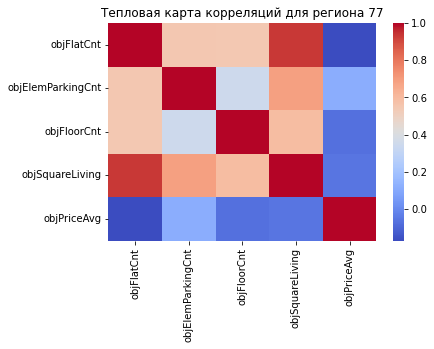

In [92]:
viz = Visualizer(objects_detailed.df)
viz.make_heatmap(77)

In [93]:
viz.make_boxplot()